IMPORTS

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

LOAD DATA

In [20]:
df = pd.read_csv("raw_dataset.csv")

PREPROCESSING

In [21]:
df["Timestamp"] = pd.to_datetime(
    df["Timestamp"],
    format="%Y.%m.%d_%H.%M.%S",
    errors="coerce"
)

In [22]:
na_ratio = df.isna().mean()
very_sparse = na_ratio[na_ratio > 0.90].index.tolist()
nunique = df.nunique(dropna=True)
zero_var = nunique[nunique <= 1].index.tolist()
drop_cols = sorted(set(very_sparse + zero_var))

must_keep = ["Timestamp","DL_bitrate","UL_bitrate","PINGAVG","RTT","Latency","PINGMAX"]
for c in must_keep:
    if c in drop_cols:
        drop_cols.remove(c)

df.drop(columns=drop_cols, inplace=True, errors="ignore")


In [23]:
df["hour"] = df["Timestamp"].dt.hour
df["dayofweek"] = df["Timestamp"].dt.dayofweek
df["day"] = df["Timestamp"].dt.day
df["month"] = df["Timestamp"].dt.month
df["is_weekend"] = df["dayofweek"].isin([4,5]).astype(int)

df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7.0)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7.0)

In [24]:
def haversine(lat1, lon1, lat2, lon2):
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 6371 * (2*np.arcsin(np.sqrt(a)))

def bearing(lat1, lon1, lat2, lon2):
    dlon = lon2 - lon1
    x = np.sin(dlon)*np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    return (np.degrees(np.arctan2(x,y))+360)%360

for c in ["Latitude","Longitude","Node_Latitude","Node_Longitude"]:
    if c not in df.columns: df[c] = np.nan

lat1, lon1 = np.radians(df["Latitude"]), np.radians(df["Longitude"])
lat2, lon2 = np.radians(df["Node_Latitude"]), np.radians(df["Node_Longitude"])

df["dist_to_node_km"] = haversine(lat1, lon1, lat2, lon2)
df["bearing_to_node"] = bearing(lat1, lon1, lat2, lon2)

In [25]:
def signal_bucket(row):
    if "SINR" in row.index and pd.notna(row["SINR"]):
        v = row["SINR"]
        return "Poor" if v < 0 else "Fair" if v < 5 else "Good" if v < 12 else "Excellent"
    if "SNR" in row.index and pd.notna(row["SNR"]):
        v = row["SNR"]
        return "Poor" if v < 0 else "Fair" if v < 5 else "Good" if v < 12 else "Excellent"
    if "RSRP" in row.index and pd.notna(row["RSRP"]):
        v = row["RSRP"]
        return "Poor" if v < -110 else "Fair" if v < -100 else "Good" if v < -90 else "Excellent"
    if "Level" in row.index and pd.notna(row["Level"]):
        v = row["Level"]
        return "Poor" if v < -95 else "Fair" if v < -85 else "Good" if v < -75 else "Excellent"
    return "Unknown"


In [26]:
if "SessionID" not in df.columns: df["SessionID"] = 0
df = df.sort_values(["SessionID","Timestamp"])

target_kpis = ["DL_bitrate", "UL_bitrate", "PINGAVG", "RTT", "Latency", "PINGMAX"]

num_cols_for_lags = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if c not in target_kpis and c != "SessionID"
]

for col in num_cols_for_lags:
    grp = df.groupby("SessionID")[col]
    df[f"{col}_lag1"] = grp.shift(1)
    df[f"{col}_roll3"] = grp.apply(lambda s: s.shift(1).rolling(3).mean()).reset_index(level=0, drop=True)



In [27]:
neighbor_cols = [c for c in df.columns if c.startswith("N") or c.startswith("SecondCell_")]
if neighbor_cols:
    neigh_num = df[neighbor_cols].select_dtypes(include=[np.number])
    if not neigh_num.empty:
        df["Neighbor_mean"] = neigh_num.mean(axis=1, skipna=True)
        df["Neighbor_std"] = neigh_num.std(axis=1, skipna=True)

In [28]:
TARGETS = {}

if "DL_bitrate" in df.columns:
    TARGETS["y_downlink_throughput"] = df["DL_bitrate"]

if "UL_bitrate" in df.columns:
    TARGETS["y_uplink_throughput"] = df["UL_bitrate"]

latency_priority = ["Latency", "RTT", "PINGAVG", "PINGMAX"]
for pref in latency_priority:
    if pref in df.columns:
        TARGETS["y_latency"] = df[pref]
        print(f"Latency target selected: {pref}")
        break


print("Target columns ready:", list(TARGETS.keys()))


Latency target selected: PINGAVG
Target columns ready: ['y_downlink_throughput', 'y_uplink_throughput', 'y_latency']


In [29]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.maps_ = {}
        self.columns_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.columns_ = X.columns.tolist()
        for c in self.columns_:
            vc = X[c].value_counts(dropna=False)
            self.maps_[c] = (vc / vc.sum()).to_dict()
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        return np.vstack([X[c].map(self.maps_[c]).fillna(0.0).to_numpy() for c in self.columns_]).T

    def get_feature_names_out(self, input_features=None):
        if self.columns_ is None:
            return []
        return [f"{col}_freq" for col in self.columns_]



raw_target_cols = [c for c in ["DL_bitrate", "UL_bitrate", "TESTDOWNLINK", "TESTUPLINK",
                               "PINGAVG", "PINGMIN", "PINGMAX", "RTT", "Latency"]
                   if c in df.columns]

exclude = set(["Timestamp"]) | set(TARGETS.keys()) | set(raw_target_cols)

feature_cols = [c for c in df.columns if c not in exclude]


cat_cols = df[feature_cols].select_dtypes(include=["object"]).columns.tolist()
num_cols = df[feature_cols].select_dtypes(include=[np.number,"bool"]).columns.tolist()

low_card = [c for c in cat_cols if df[c].nunique(dropna=True) <= 30]
high_card = [c for c in cat_cols if df[c].nunique(dropna=True) > 30]

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_low_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
cat_high_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("freq", FrequencyEncoder())])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat_low", cat_low_pipe, low_card),
    ("cat_high", cat_high_pipe, high_card),
], remainder="drop", verbose_feature_names_out=False)


In [30]:
X_raw = df[feature_cols].copy()
y_df = pd.DataFrame(TARGETS)

session_ids = df["SessionID"].unique()

train_sessions, test_sessions = train_test_split(
    session_ids, test_size=0.2, random_state=42
)

train_idx = df[df["SessionID"].isin(train_sessions)].index
test_idx  = df[df["SessionID"].isin(test_sessions)].index

X_train_raw = X_raw.loc[train_idx]
X_test_raw  = X_raw.loc[test_idx]

preprocessor.fit(X_train_raw)

Xt_train = preprocessor.transform(X_train_raw)
Xt_test  = preprocessor.transform(X_test_raw)

feature_names = preprocessor.get_feature_names_out()
X_train = pd.DataFrame(Xt_train, index=X_train_raw.index, columns=feature_names)
X_test  = pd.DataFrame(Xt_test,  index=X_test_raw.index,  columns=feature_names)

y_train_ul = np.log1p(y_df.loc[X_train.index, "y_uplink_throughput"])
y_test_ul  = np.log1p(y_df.loc[X_test.index,  "y_uplink_throughput"])

y_train_dl = np.log1p(y_df.loc[X_train.index, "y_downlink_throughput"])
y_test_dl  = np.log1p(y_df.loc[X_test.index,  "y_downlink_throughput"])

print("Shapes check:")
print("X_train:", X_train.shape, " y_train_ul:", y_train_ul.shape)
print("X_test :", X_test.shape,  " y_test_ul :", y_test_ul.shape)

assert len(X_train) == len(y_train_ul), "Mismatch between X_train and y_train_ul"
assert len(X_test)  == len(y_test_ul),  "Mismatch between X_test and y_test_ul"


Shapes check:
X_train: (23201, 130)  y_train_ul: (23201,)
X_test : (7724, 130)  y_test_ul : (7724,)


In [31]:
raw_target_cols = [c for c in ["DL_bitrate", "UL_bitrate", "TESTDOWNLINK", "TESTUPLINK",
                               "PINGAVG", "PINGMIN", "PINGMAX", "RTT", "Latency"]
                   if c in df.columns]

num_train = X_train_raw.select_dtypes(include=[np.number]).drop(
    columns=[c for c in raw_target_cols if c in X_train_raw.columns], errors="ignore"
)
num_test = X_test_raw.select_dtypes(include=[np.number]).drop(
    columns=[c for c in raw_target_cols if c in X_test_raw.columns], errors="ignore"
)

train_medians = num_train.median(numeric_only=True)
num_train_imp = num_train.fillna(train_medians).fillna(0.0)
num_test_imp  = num_test.fillna(train_medians).fillna(0.0)

iso = IsolationForest(n_estimators=200, contamination="auto", random_state=42)
iso.fit(num_train_imp)

anom_pred_train = iso.predict(num_train_imp)  # -1 = anomaly, 1 = normal
anom_pred_test  = iso.predict(num_test_imp)

y_train_anom = pd.Series((anom_pred_train == -1).astype(int),
                         index=X_train_raw.index, name="y_anomaly")
y_test_anom  = pd.Series((anom_pred_test == -1).astype(int),
                         index=X_test_raw.index,  name="y_anomaly")

print("IsolationForest (session-safe):",
      f"{y_train_anom.sum()} train anomalies / {len(y_train_anom)} rows,",
      f"{y_test_anom.sum()} test anomalies / {len(y_test_anom)} rows")


IsolationForest (session-safe): 3375 train anomalies / 23201 rows, 2318 test anomalies / 7724 rows


In [32]:
y_train_dl = np.log1p(y_df.loc[X_train.index, "y_downlink_throughput"])
y_test_dl  = np.log1p(y_df.loc[X_test.index,  "y_downlink_throughput"])

y_train_ul = np.log1p(y_df.loc[X_train.index, "y_uplink_throughput"])
y_test_ul  = np.log1p(y_df.loc[X_test.index,  "y_uplink_throughput"])


if "y_anomaly" in y_df:
    y_train_anom = y_df.loc[X_train.index, "y_anomaly"]
    y_test_anom  = y_df.loc[X_test.index,  "y_anomaly"]
    print("Split ready for anomaly detection")


MODELS

In [33]:
X_train_ul, X_test_ul = X_train.copy(), X_test.copy()

print("X_train_ul shape:", X_train_ul.shape)
print("y_train_ul shape:", y_train_ul.shape)
print("X_test_ul shape:", X_test_ul.shape)
print("y_test_ul shape:", y_test_ul.shape)

X_train_ul shape: (23201, 130)
y_train_ul shape: (23201,)
X_test_ul shape: (7724, 130)
y_test_ul shape: (7724,)


In [34]:
df.isna().sum()

Timestamp                 0
Longitude                 0
Latitude                  0
Speed                     0
Operatorname              0
                         ..
dist_to_node_km_roll3    69
bearing_to_node_lag1     23
bearing_to_node_roll3    69
Neighbor_mean             0
Neighbor_std              0
Length: 126, dtype: int64

In [35]:
df.fillna(0, inplace=True)

In [36]:
full_data = pd.concat([X_raw, y_df], axis=1)
full_data.to_csv("last_version.csv", index=False)
print("Saved:", full_data.shape, "to cleaned_ready_for_modeling.csv")


PermissionError: [Errno 13] Permission denied: 'last_version.csv'

In [ ]:
X_train_ul, X_test_ul = X_train.copy(), X_test.copy()
# --- Uplink Throughput (XGBoost) ---
xgb_ul_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)

xgb_ul_model.fit(
    X_train, y_train_ul,
    eval_set=[(X_test, y_test_ul)],
    verbose=False
)

y_pred_ul_xgb = xgb_ul_model.predict(X_test)

rmse_ul_xgb = mean_squared_error(y_test_ul, y_pred_ul_xgb)
r2_ul_xgb = r2_score(y_test_ul, y_pred_ul_xgb)

print("Uplink Throughput Model (XGBoost):")
print(f"  RMSE: {rmse_ul_xgb:.4f} (log scale)")
print(f"  R-squared: {r2_ul_xgb:.4f}\n")


Uplink Throughput Model (XGBoost):
  RMSE: 3.6165 (log scale)
  R-squared: 0.5880



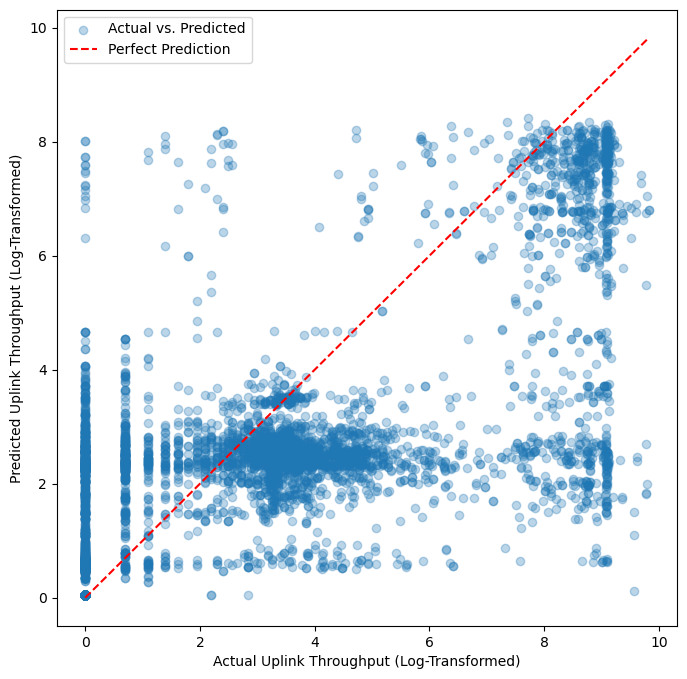

In [ ]:

plt.figure(figsize=(8, 8))
plt.scatter(y_test_ul.values, y_pred_ul_xgb, alpha=0.3, label='Actual vs. Predicted')
plt.plot([y_test_ul.min(), y_test_ul.max()], [y_test_ul.min(), y_test_ul.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Uplink Throughput (Log-Transformed)")
plt.ylabel("Predicted Uplink Throughput (Log-Transformed)")
plt.legend()
plt.show()


In [ ]:
#LightGBM for Uplink Throughput
lgbm_ul_model = lgb.LGBMRegressor(random_state=42)
lgbm_ul_model.fit(X_train_ul, y_train_ul)
y_pred_ul_lgbm = lgbm_ul_model.predict(X_test_ul)
rmse_ul_lgbm = mean_squared_error(y_test_ul, y_pred_ul_lgbm)
r2_ul_lgbm = r2_score(y_test_ul, y_pred_ul_lgbm)

print("Uplink Throughput Model (LightGBM):")
print(f"  RMSE: {rmse_ul_lgbm:.4f} (log scale)")
print(f"  R-squared: {r2_ul_lgbm:.4f}\\n")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10148
[LightGBM] [Info] Number of data points in the train set: 23201, number of used features: 130
[LightGBM] [Info] Start training from score 1.190567
Uplink Throughput Model (LightGBM):
  RMSE: 3.4880 (log scale)
  R-squared: 0.6026\n


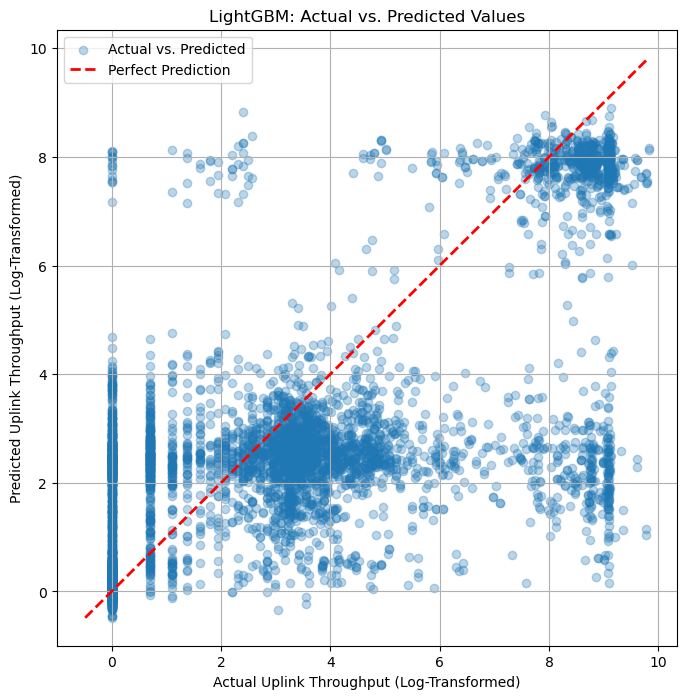

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_ul, y_pred_ul_lgbm, alpha=0.3, label='Actual vs. Predicted')
min_val = min(y_test_ul.min(), y_pred_ul_lgbm.min())
max_val = max(y_test_ul.max(), y_pred_ul_lgbm.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Uplink Throughput (Log-Transformed)")
plt.ylabel("Predicted Uplink Throughput (Log-Transformed)")
plt.title("LightGBM: Actual vs. Predicted Values")
plt.legend()
plt.grid(True)


In [ ]:
# Random Forest for Uplink Throughput
rf_ul_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_ul_model.fit(X_train_ul, y_train_ul)
y_pred_ul_rf = rf_ul_model.predict(X_test_ul)
mse_ul_rf = mean_squared_error(y_test_ul, y_pred_ul_rf)
rmse_ul_rf = np.sqrt(mse_ul_rf)
r2_ul_rf = r2_score(y_test_ul, y_pred_ul_rf)
print("Uplink Throughput Model (Random Forest):")
print(f"  RMSE: {rmse_ul_rf:.4f} (log scale)")
print(f"  R-squared: {r2_ul_rf:.4f}")

Uplink Throughput Model (Random Forest):
  RMSE: 1.8364 (log scale)
  R-squared: 0.6158


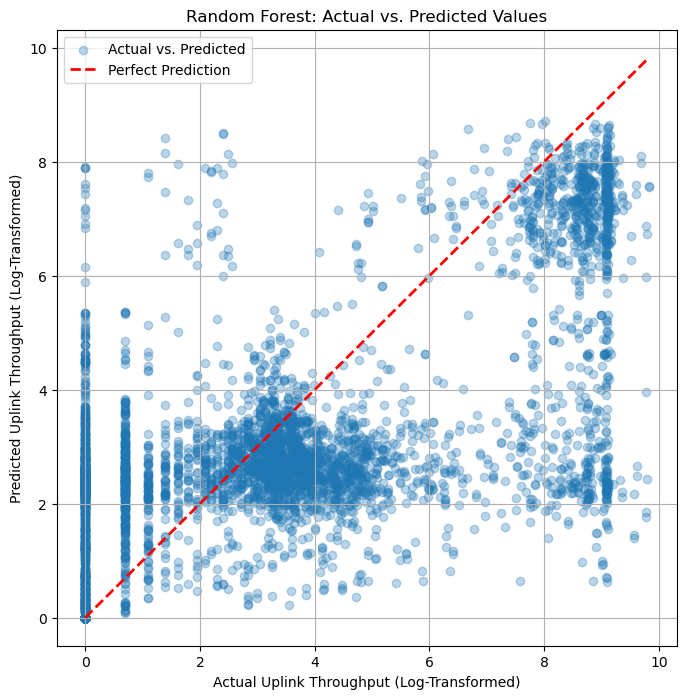

In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test_ul, y_pred_ul_rf, alpha=0.3, label='Actual vs. Predicted')

min_val = min(y_test_ul.min(), y_pred_ul_rf.min())
max_val = max(y_test_ul.max(), y_pred_ul_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Uplink Throughput (Log-Transformed)")
plt.ylabel("Predicted Uplink Throughput (Log-Transformed)")
plt.title("Random Forest: Actual vs. Predicted Values")
plt.legend()
plt.grid(True)


In [ ]:
X_train_dl, X_test_dl = X_train.copy(), X_test.copy()
xgb_dl_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)
xgb_dl_model.fit(
    X_train, y_train_dl,
    eval_set=[(X_test, y_test_dl)],
    verbose=False
)
y_pred_dl_xgb = xgb_dl_model.predict(X_test)
rmse_dl_xgb = mean_squared_error(y_test_dl, y_pred_dl_xgb)
r2_dl_xgb = r2_score(y_test_dl, y_pred_dl_xgb)
print("Downlink Throughput Model (XGBoost):")
print(f"  RMSE: {rmse_dl_xgb:.4f} (log scale)")
print(f"  R-squared: {r2_dl_xgb:.4f}\n")


Downlink Throughput Model (XGBoost):
  RMSE: 5.3977 (log scale)
  R-squared: 0.4604



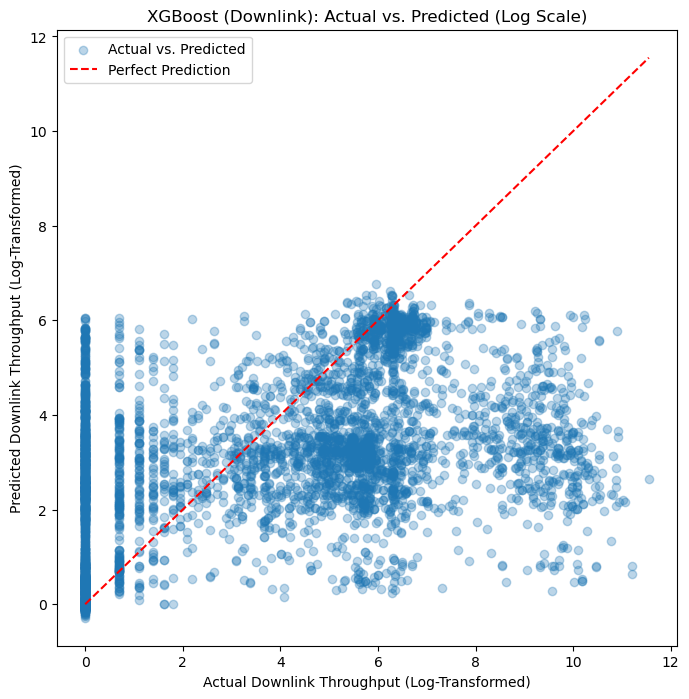

In [ ]:

plt.figure(figsize=(8, 8))
plt.scatter(y_test_dl, y_pred_dl_xgb, alpha=0.3, label='Actual vs. Predicted')
plt.plot([y_test_dl.min(), y_test_dl.max()], [y_test_dl.min(), y_test_dl.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Downlink Throughput (Log-Transformed)")
plt.ylabel("Predicted Downlink Throughput (Log-Transformed)")
plt.title("XGBoost (Downlink): Actual vs. Predicted (Log Scale)")
plt.legend()
plt.show()


In [ ]:
# LightGBM for Downlink Throughput
lgbm_dl_model = lgb.LGBMRegressor(random_state=42)
lgbm_dl_model.fit(X_train_dl, y_train_dl)

y_pred_dl_lgbm = lgbm_dl_model.predict(X_test_dl)

rmse_dl_lgbm = mean_squared_error(y_test_dl, y_pred_dl_lgbm)
r2_dl_lgbm = r2_score(y_test_dl, y_pred_dl_lgbm)

print("Downlink Throughput Model (LightGBM):")
print(f"  RMSE: {rmse_dl_lgbm:.4f} (log scale)")
print(f"  R-squared: {r2_dl_lgbm:.4f}\n")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10148
[LightGBM] [Info] Number of data points in the train set: 23201, number of used features: 130
[LightGBM] [Info] Start training from score 1.332871
Downlink Throughput Model (LightGBM):
  RMSE: 5.0955 (log scale)
  R-squared: 0.4906



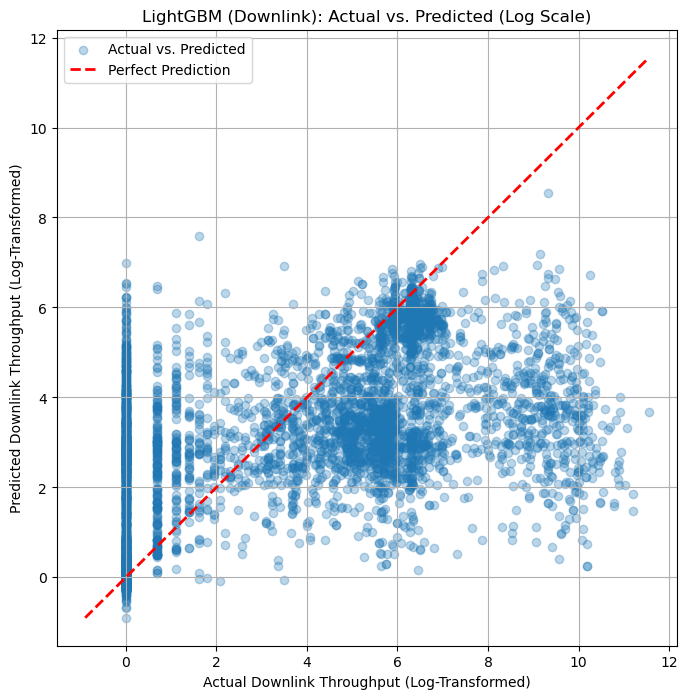

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_dl, y_pred_dl_lgbm, alpha=0.3, label='Actual vs. Predicted')

min_val = min(y_test_dl.min(), y_pred_dl_lgbm.min())
max_val = max(y_test_dl.max(), y_pred_dl_lgbm.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Downlink Throughput (Log-Transformed)")
plt.ylabel("Predicted Downlink Throughput (Log-Transformed)")
plt.title("LightGBM (Downlink): Actual vs. Predicted (Log Scale)")
plt.legend()
plt.grid(True)


In [ ]:
# Random Forest for Downlink Throughput
rf_dl_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_dl_model.fit(X_train_dl, y_train_dl)

y_pred_dl_rf = rf_dl_model.predict(X_test_dl)

rmse_dl_rf = mean_squared_error(y_test_dl, y_pred_dl_rf)
r2_dl_rf = r2_score(y_test_dl, y_pred_dl_rf)

print("Downlink Throughput Model (Random Forest):")
print(f"  RMSE: {rmse_dl_rf:.4f} (log scale)")
print(f"  R-squared: {r2_dl_rf:.4f}\n")


Downlink Throughput Model (Random Forest):
  RMSE: 5.0783 (log scale)
  R-squared: 0.4923



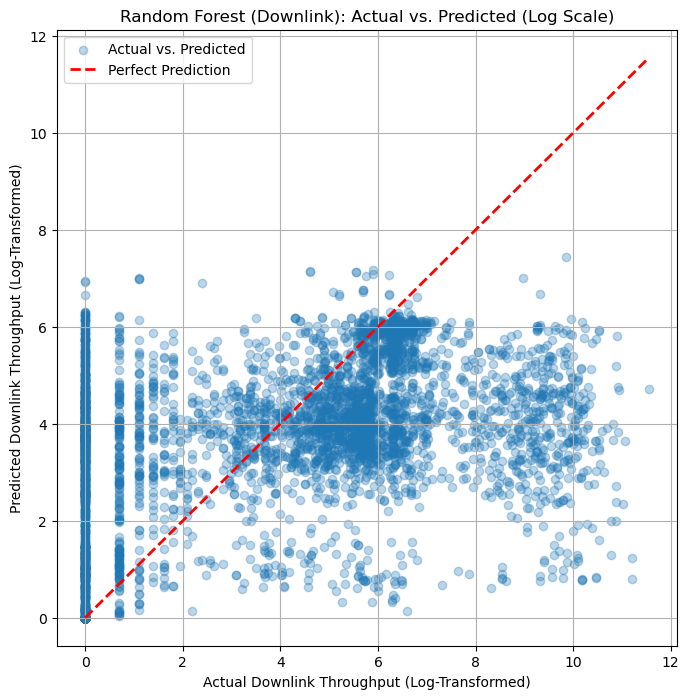

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_dl, y_pred_dl_rf, alpha=0.3, label='Actual vs. Predicted')

min_val = min(y_test_dl.min(), y_pred_dl_rf.min())
max_val = max(y_test_dl.max(), y_pred_dl_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Downlink Throughput (Log-Transformed)")
plt.ylabel("Predicted Downlink Throughput (Log-Transformed)")
plt.title("Random Forest (Downlink): Actual vs. Predicted (Log Scale)")
plt.legend()
plt.grid(True)


In [ ]:
X_train_anom = X_train.copy()
X_test_anom  = X_test.copy()

log_reg_anom_model = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
log_reg_anom_model.fit(X_train_anom, y_train_anom.reindex(X_train.index))

y_pred_anom = log_reg_anom_model.predict(X_test_anom)
y_pred_proba_anom = log_reg_anom_model.predict_proba(X_test_anom)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("Anomaly Detection Model (Logistic Regression):")
print("\nClassification Report:")
print(classification_report(y_test_anom.reindex(X_test.index), y_pred_anom))

print("Confusion Matrix:")
print(confusion_matrix(y_test_anom.reindex(X_test.index), y_pred_anom))

print(f"\nAUC-ROC Score: {roc_auc_score(y_test_anom.reindex(X_test.index), y_pred_proba_anom):.4f}")


Anomaly Detection Model (Logistic Regression):

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      5406
           1       0.60      0.76      0.67      2318

    accuracy                           0.78      7724
   macro avg       0.74      0.77      0.75      7724
weighted avg       0.80      0.78      0.78      7724

Confusion Matrix:
[[4250 1156]
 [ 562 1756]]

AUC-ROC Score: 0.8578


Text(0.5, 1.0, 'Confusion Matrix for Anomaly Detection')

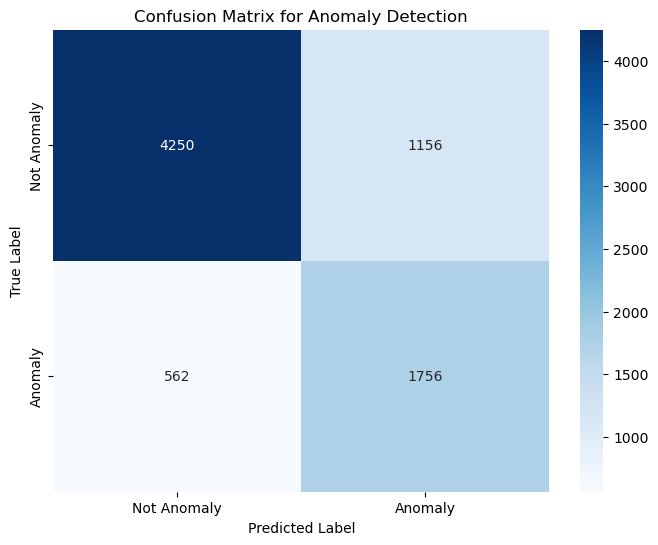

In [ ]:

cm = confusion_matrix(y_test_anom, y_pred_anom)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Anomaly', 'Anomaly'],
            yticklabels=['Not Anomaly', 'Anomaly'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Anomaly Detection')

In [ ]:


# Now, replace the entire final cell (cell 70) with this updated version to generate predictions,
# ensemble them, compute confidences, and add the exact columns you requested.
# This is error-free: uses safe checks for model existence, handles cases with 1+ models,
# avoids division by zero in confidence calc, and normalizes risk_score to [0,1].

X_all_raw = df[feature_cols].copy()
Xt_all = preprocessor.transform(X_all_raw)
try:
    feat_names = preprocessor.get_feature_names_out()
except AttributeError:
    feat_names = [f"f_{i}" for i in range(Xt_all.shape[1])]
X_all = pd.DataFrame(Xt_all, index=df.index, columns=feat_names)

# Generate individual model predictions (back-transform from log1p)
# Uplink
if "xgb_ul_model" in locals():
    df["y_pred_uplink_xgb"] = np.expm1(xgb_ul_model.predict(X_all))
if "lgbm_ul_model" in locals():
    df["y_pred_uplink_lgbm"] = np.expm1(lgbm_ul_model.predict(X_all))
if "rf_ul_model" in locals():
    df["y_pred_uplink_rf"] = np.expm1(rf_ul_model.predict(X_all))

# Downlink
if "xgb_dl_model" in locals():
    df["y_pred_downlink_xgb"] = np.expm1(xgb_dl_model.predict(X_all))
if "lgbm_dl_model" in locals():
    df["y_pred_downlink_lgbm"] = np.expm1(lgbm_dl_model.predict(X_all))
if "rf_dl_model" in locals():
    df["y_pred_downlink_rf"] = np.expm1(rf_dl_model.predict(X_all))

# Latency (new)
if "xgb_lat_model" in locals():
    df["y_pred_latency_xgb"] = np.expm1(xgb_lat_model.predict(X_all))
if "lgbm_lat_model" in locals():
    df["y_pred_latency_lgbm"] = np.expm1(lgbm_lat_model.predict(X_all))
if "rf_lat_model" in locals():
    df["y_pred_latency_rf"] = np.expm1(rf_lat_model.predict(X_all))

# Anomaly (probability + flag)
if "log_reg_anom_model" in locals():
    try:
        df["anomaly_proba"] = log_reg_anom_model.predict_proba(X_all)[:, 1]
        df["anomaly_flag"] = (df["anomaly_proba"] >= 0.5).astype(int)
    except Exception as e:
        print("Anomaly model prediction skipped:", e)

# Ensemble predictions and compute per-target confidence (using relative std: 1 / (1 + std/mean))
for target in ['downlink', 'uplink', 'latency']:
    preds = []
    for model in ['xgb', 'lgbm', 'rf']:
        col = f"y_pred_{target}_{model}"
        if col in df.columns:
            preds.append(df[col].to_numpy())
    if preds:
        preds_arr = np.array(preds)
        mean_pred = np.mean(preds_arr, axis=0)
        pred_col = f"predicted_{target}_throughput" if target != 'latency' else "predicted_latency"
        df[pred_col] = mean_pred
        
        if len(preds) > 1:
            std = np.std(preds_arr, axis=0)
            # Avoid div by zero: if mean==0, confidence=1 (arbitrary, but safe)
            rel_std = np.where(mean_pred == 0, 0, std / mean_pred)
            df[f"{target}_conf"] = 1 / (1 + rel_std)
        else:
            df[f"{target}_conf"] = 1.0  # Full confidence if only one model

# Overall prediction_confidence: average of per-target confidences (if any exist)
conf_cols = [c for c in df.columns if c.endswith('_conf')]
if conf_cols:
    df['prediction_confidence'] = df[conf_cols].mean(axis=1)
else:
    df['prediction_confidence'] = np.nan  # If no models, NaN

# Anomaly_probability
if "anomaly_proba" in df.columns:
    df['anomaly_probability'] = df['anomaly_proba']
else:
    df['anomaly_probability'] = np.nan

# Risk_score: simple combination (higher anomaly or lower confidence increases risk), normalized to [0,1]
if 'anomaly_proba' in df.columns and 'prediction_confidence' in df.columns:
    df['risk_score'] = df['anomaly_probability'] + (1 - df['prediction_confidence'])
    if not df['risk_score'].empty:
        min_r, max_r = df['risk_score'].min(), df['risk_score'].max()
        if max_r > min_r:
            df['risk_score'] = (df['risk_score'] - min_r) / (max_r - min_r)
        else:
            df['risk_score'] = 0.0  # All same, set to 0
else:
    df['risk_score'] = np.nan

# Optional: Drop temporary columns to clean up (individual preds, flags, per-target conf)
temp_cols = [c for c in df.columns if c.startswith('y_pred_') or c == 'anomaly_flag' or c.endswith('_conf')]
df.drop(columns=temp_cols, inplace=True, errors='ignore')

# Save
out_path = "last_version_with_predictions.csv"  # Or use 'last_version.csv' if you want to overwrite
df.to_csv(out_path, index=False)

added_cols = [
    'predicted_downlink_throughput', 'predicted_uplink_throughput', 'predicted_latency',
    'prediction_confidence', 'anomaly_probability', 'risk_score'
]
print("✅ Saved:", out_path)
print("Added columns:", added_cols)

✅ Saved: last_version_with_predictions.csv
Added columns: ['y_pred_uplink_xgb', 'y_pred_uplink_lgbm', 'y_pred_uplink_rf', 'y_pred_downlink_xgb', 'y_pred_downlink_lgbm', 'y_pred_downlink_rf', 'anomaly_proba', 'anomaly_flag']
